In [25]:
from dataclasses import dataclass
from typing import List, Optional
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import numpy as np

import torch
import faster_whisper
import whisper

import IPython.display as ipd

In [4]:
def readAudioFile(audio_path):
    audio, sample_rate = sf.read(audio_path)
    if audio.ndim > 1:
        audio = audio[:, 0]
    if sample_rate != 16000:
        audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=16000)
    return audio.astype("float32")

In [5]:
audio=readAudioFile("/mnt/e/Download/ja_test_0/common_voice_ja_19485593.mp3")
ipd.Audio(audio, rate=16000)

In [32]:
def displayLogMelSpectrogram(mel):
    # display log mel spectrogram IPython.display
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, x_axis='time', y_axis='mel', sr=16000, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

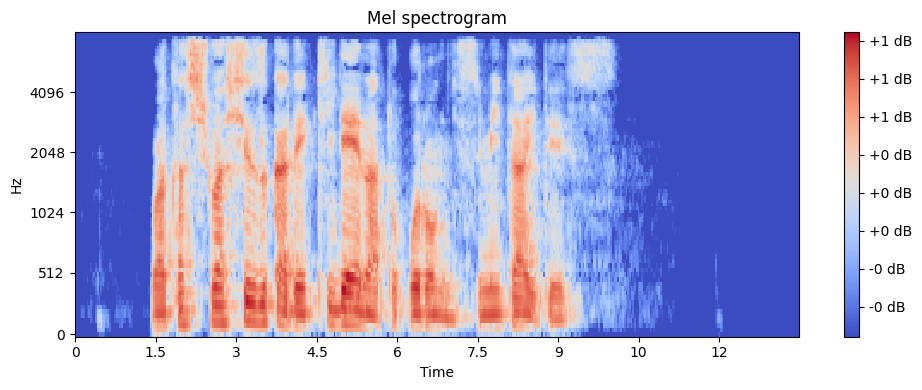

In [33]:
mel = whisper.audio.log_mel_spectrogram(audio)
# torch.float32 to np.float32
mel=mel.cpu().detach().numpy()

# display log mel spectrogram IPython.display
displayLogMelSpectrogram(mel)

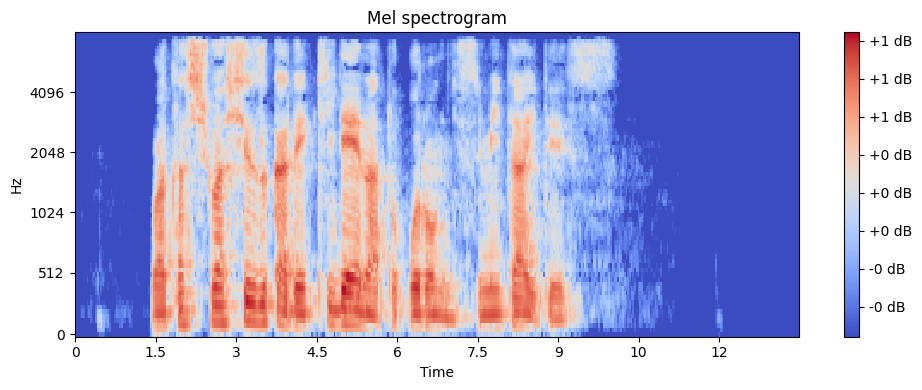

In [34]:
# get log_mel_spectrogram using faster whisper
# https://github.com/guillaumekln/faster-whisper/blob/5a0541ea7d054aa3716ac492491de30158c20057/faster_whisper/feature_extractor.py#L48
"""
Compute the log-Mel spectrogram of the provided audio, gives similar results
whisper's original torch implementation with 1e-5 tolerance.
"""
ft=faster_whisper.feature_extractor.FeatureExtractor()

window = np.hanning(ft.n_fft + 1)[:-1]

frames = ft.fram_wave(audio)
stft = ft.stft(frames, window=window)
magnitudes = np.abs(stft[:, :-1]) ** 2

filters = ft.mel_filters
mel_spec = filters @ magnitudes

log_spec = np.log10(np.clip(mel_spec, a_min=1e-10, a_max=None))
log_spec = np.maximum(log_spec, log_spec.max() - 8.0)
mel = (log_spec + 4.0) / 4.0

displayLogMelSpectrogram(mel)


In [35]:
from faster_whisper.feature_extractor import FeatureExtractor

def calculate_audio_features(audio_path: Optional[str], ft: FeatureExtractor) -> List[float]:
    if audio_path is None:
        audio = np.zeros(16000)
    else:
        audio = readAudioFile(audio_path)
    window = np.hanning(ft.n_fft + 1)[:-1]

    frames = ft.fram_wave(audio)
    stft = ft.stft(frames, window=window)
    magnitudes = np.abs(stft[:, :-1]) ** 2

    filters = ft.mel_filters
    mel_spec = filters @ magnitudes

    log_spec = np.log10(np.clip(mel_spec, a_min=1e-10, a_max=None))
    log_spec = np.maximum(log_spec, log_spec.max() - 8.0)
    mel = (log_spec + 4.0) / 4.0
    return mel

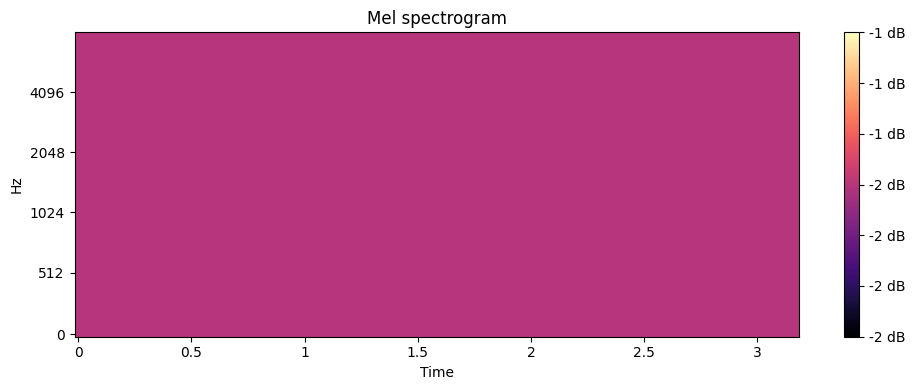

In [36]:
class_names='''[cat]
[keyboard_typing]
[sneezing]
[laughing]
[breathing]
'''
class_names = [c.strip() for c in class_names.split("\n")]
class_names.pop()

ft = FeatureExtractor()
audio_features_from_empty_input = calculate_audio_features(None, ft)

displayLogMelSpectrogram(audio_features_from_empty_input)



In [37]:
import sys
import os
from pathlib import Path

base_dir=f'{Path(os.getcwd()).parent}'
sys.path.append(base_dir)

model = faster_whisper.WhisperModel(
    "base",
    device="cuda",
    compute_type="float32",
    download_root=f"{base_dir}/.model_cache",
)

In [72]:
sampling_rate = 16000
duration = audio.shape[0] / sampling_rate
features = audio_features_from_empty_input
language = "ja"

tokenizer = faster_whisper.tokenizer.Tokenizer(
        model.hf_tokenizer,
        model.model.is_multilingual,
        task="transcribe",
        language="ja",
    )
class_names='''[cat]
[keyboard_typing]
[sneezing]
[laughing]
[breathing]
'''
class_names = [c.strip() for c in class_names.split("\n")]
class_names.pop()

from faster_whisper.transcribe import TranscriptionOptions

for i,class_name in enumerate(class_names):
    class_name_tokens = tokenizer.encode(class_name)
    encoder_output = model.encode(features)
    prompt = model.get_prompt(
        tokenizer,
        class_name_tokens,
        without_timestamps=True,
        prefix=None
    )
    options = TranscriptionOptions(
        beam_size=3,
        best_of=5,
        patience=1.0,
        length_penalty=1.0,
        repetition_penalty=1.0,
        no_repeat_ngram_size=0,
        log_prob_threshold=-1.0,
        no_speech_threshold=0.6,
        compression_ratio_threshold=2.4,
        condition_on_previous_text=False,
        prompt_reset_on_temperature=0.5,
        temperatures= [
            0.0,
            0.2,
            0.4,
            0.6,
            0.8,
            1.0,
        ],
        initial_prompt="",
        prefix="",
        suppress_blank=True,
        suppress_tokens=[],
        without_timestamps=True,
        max_initial_timestamp=0.0,
        word_timestamps=False,
        prepend_punctuations = "\"'“¿([{-",
        append_punctuations = "\"'.。,，!！?？:：”)]}、",       
    )
    print(f'{i} {class_name} {class_name_tokens}')
    (
        result,
        avg_logprob,
        temperature,
        compression_ratio,
    ) = model.generate_with_fallback(encoder_output,
                                     prompt, tokenizer,options)
    print(avg_logprob)


to_cpu False
0 [cat] [58, 18035, 60]
WhisperGenerationResult(sequences=[['[', 'éĸ', '¢', 'å¿ĥ', ']']], sequences_ids=[[58, 5196, 95, 7945, 60]], scores=[-1.529089331626892], no_speech_prob=0.8553821444511414)
to_cpu False
1 [keyboard_typing] [58, 4119, 3787, 62, 874, 3381, 60]
WhisperGenerationResult(sequences=[['[', 'key', 'board', '_', 'ty', 'ping', ']']], sequences_ids=[[58, 4119, 3787, 62, 874, 3381, 60]], scores=[-0.1264134794473648], no_speech_prob=0.7348949909210205)
to_cpu False
2 [sneezing] [58, 82, 716, 4371, 278, 60]
WhisperGenerationResult(sequences=[['[', 's', 'ne', 'ez', 'ing', ']']], sequences_ids=[[58, 82, 716, 4371, 278, 60]], scores=[-0.28004470467567444], no_speech_prob=0.8139881491661072)
to_cpu False
3 [laughing] [58, 4986, 60]
WhisperGenerationResult(sequences=[['[', 'music', ']']], sequences_ids=[[58, 7572, 60]], scores=[-1.2033835649490356], no_speech_prob=0.8249141573905945)
to_cpu False
4 [breathing] [58, 47674, 571, 60]
WhisperGenerationResult(sequences=[['['